*Test library imports*

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete!")


✓ Setup complete!


*List down all sheets*

In [6]:
# Load the Excel file
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'

# Check what sheets are available
excel_file = pd.ExcelFile(file_path)
print("Available sheets:")
for i, sheet in enumerate(excel_file.sheet_names, 1):
    print(f"{i:2d}. {sheet}")


Available sheets:
 1. Combined (All)
 2. TBills
 3. SZNE
 4. Inflation
 5. Interest Rate
 6. S&P500
 7. Healthcare
 8. Utilities
 9. Discretionary
10. Staples
11. Energy
12. Materials
13. Financials
14. Industrials
15. Tech
16. Comm. Services
17. Real Estate


*Preprocess S&P 500 data for analysis*

In [10]:
# The data structure:
# - Row 0-1: Headers and metadata
# - Row 2: Column headers (months)
# - Row 3-5: Max/Min/Avg
# - Row 6+: Years with monthly returns

# Skip first 6 rows to get to actual data
df_sp500 = pd.read_excel(file_path, sheet_name='S&P500', skiprows=6)

# First column is years
df_sp500 = df_sp500.iloc[:, 1:]  # Drop first unnamed column
df_sp500.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Remove any summary rows (look for non-numeric years)
df_sp500 = df_sp500[pd.to_numeric(df_sp500['Year'], errors='coerce').notna()]
df_sp500['Year'] = df_sp500['Year'].astype(int)

# Set year as index
df_sp500 = df_sp500.set_index('Year')

# Remove rows with summary stats (e.g., decade averages)
# Keep only observed years up to 1994 (drop later summary rows)
df_sp500 = df_sp500[df_sp500.index <= 1994]

print("Cleaned S&P 500 data:")
print(f"Shape: {df_sp500.shape}")
print(f"Years: {df_sp500.index.min()} to {df_sp500.index.max()}")
print(f"\nFirst few rows:")
print(df_sp500.head())
print(f"\nLast few rows:")
print(df_sp500.tail())

Cleaned S&P 500 data:
Shape: (56, 12)
Years: 1970 to 2025

First few rows:
       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug    Sep   Oct    Nov   Dec
Year                                                                          
1970 -7.65  5.27  0.15 -9.05 -6.10 -5.00  7.33  4.45   3.30 -1.14   4.74  5.68
1971  4.05  0.91  3.68  3.63 -4.16  0.07 -4.13  3.61  -0.70 -4.18  -0.25  8.62
1972  1.81  2.16  0.59  0.44  1.73 -2.18  0.23  3.45  -0.49  0.93   4.56  1.18
1973 -1.71 -3.75 -0.14 -4.08 -1.89 -0.66  3.80 -3.67   4.01 -0.13 -11.39  1.66
1974 -1.00 -0.36 -2.33 -3.91 -3.36 -1.47 -7.78 -9.03 -11.93 16.30  -5.32 -2.02

Last few rows:
       Jan   Feb   Mar   Apr  May   Jun  Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                      
2021 -1.11  2.61  4.24  5.24 0.55  2.22 2.27  2.90 -4.76  6.91 -0.83  4.36
2022 -5.26 -3.14  3.58 -8.80 0.01 -8.39 9.11 -4.24 -9.34  7.99  5.38 -5.90
2023  6.18 -2.61  3.51  1.46 0.25  6.47 3.11 -1.77 -4.87

*Calculate some basic stats like mean, median, standard deviation on monthly data*

In [16]:
# Calculate basic statistics
print("="*70)
print("S&P 500 MONTHLY RETURNS STATISTICS (1970-2025)")
print("="*70)

# Overall statistics
print("\nAll months combined:")
all_returns = df_sp500.values.flatten()


# Solution 1: Convert to numeric first, then remove NaN
all_returns = pd.to_numeric(all_returns, errors='coerce')
all_returns = all_returns[~np.isnan(all_returns)]

print(f"Mean monthly return:    {np.mean(all_returns):.3f}%")
print(f"Median monthly return:  {np.median(all_returns):.3f}%")
print(f"Std deviation:          {np.std(all_returns):.3f}%")
print(f"Min monthly return:     {np.min(all_returns):.3f}%")
print(f"Max monthly return:     {np.max(all_returns):.3f}%")

# Statistics by month
print("\n" + "="*70)
print("AVERAGE RETURNS BY MONTH:")
print("="*70)
monthly_avgs = df_sp500.mean()
for month, avg in monthly_avgs.items():
    print(f"{month:5s}: {avg:6.2f}%")

S&P 500 MONTHLY RETURNS STATISTICS (1970-2025)

All months combined:
Mean monthly return:    0.742%
Median monthly return:  1.058%
Std deviation:          4.404%
Min monthly return:     -21.763%
Max monthly return:     16.305%

AVERAGE RETURNS BY MONTH:
Jan  :   1.08%
Feb  :   0.15%
Mar  :   0.94%
Apr  :   1.25%
May  :   0.61%
Jun  :   0.47%
Jul  :   0.98%
Aug  :   0.17%
Sep  :  -0.83%
Oct  :   0.93%
Nov  :   1.79%
Dec  :   1.39%


*Test normality*

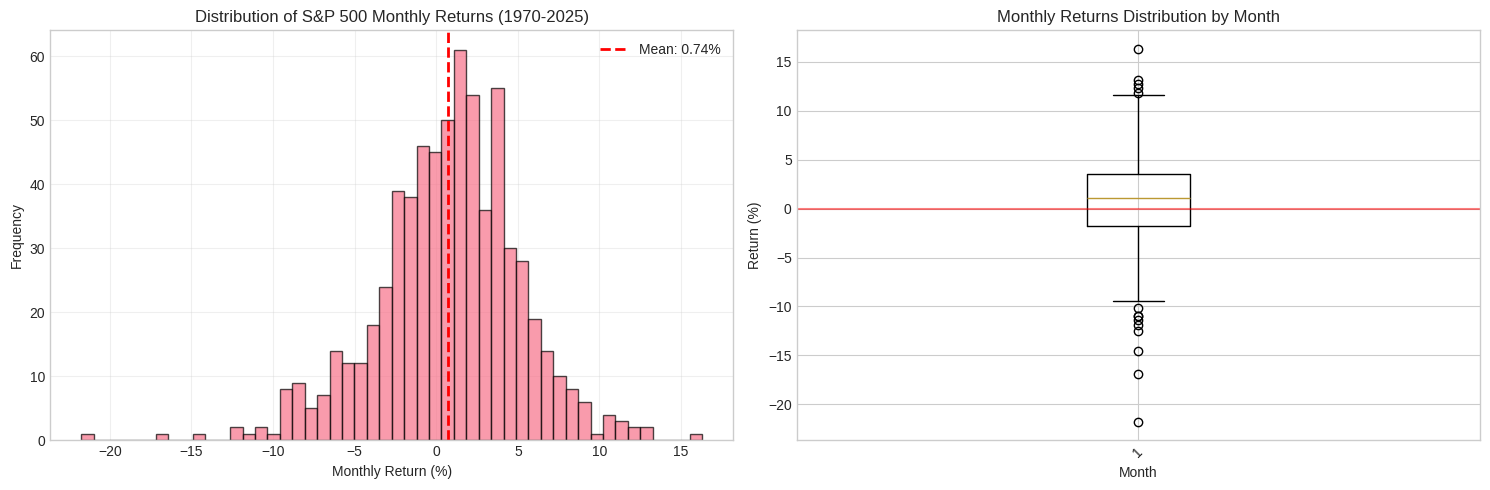


Jarque-Bera Test for Normality:
Statistic: 95.08
P-value: 0.000000
✗ Returns are NOT normally distributed (reject normality at 5% level)


In [25]:
# Create a histogram of all monthly returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(all_returns, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(all_returns), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(all_returns):.2f}%')
axes[0].set_xlabel('Monthly Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of S&P 500 Monthly Returns (1970-2025)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by month
axes[1].boxplot(all_returns)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Return (%)')
axes[1].set_title('Monthly Returns Distribution by Month')
axes[1].axhline(0, color='red', linestyle='-', alpha=0.5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check for normality
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(all_returns)
print(f"\nJarque-Bera Test for Normality:")
print(f"Statistic: {jb_stat:.2f}")
print(f"P-value: {jb_pvalue:.6f}")
if jb_pvalue < 0.05:
    print("✗ Returns are NOT normally distributed (reject normality at 5% level)")
else:
    print("✓ Returns appear normally distributed")

*Apply basic stats by seasons - summer and winter*

In [28]:
# Define seasonal periods
winter_months = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
summer_months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

# Calculate returns for each season
df_sp500['Winter_Avg'] = df_sp500[winter_months].mean(axis=1)
df_sp500['Summer_Avg'] = df_sp500[summer_months].mean(axis=1)

# Overall seasonal statistics
winter_returns = df_sp500[winter_months].values.flatten()
winter_returns = pd.to_numeric(winter_returns, errors='coerce')
winter_returns = winter_returns[~np.isnan(winter_returns)]

summer_returns = df_sp500[summer_months].values.flatten()
summer_returns = pd.to_numeric(summer_returns, errors='coerce')
summer_returns = summer_returns[~np.isnan(summer_returns)]

print("="*70)
print("SEASONAL PATTERN ANALYSIS: Nov-Apr vs May-Oct")
print("="*70)

print("\nWINTER SEASON (Nov-Apr):")
print(f"  Mean monthly return:  {np.mean(winter_returns):.3f}%")
print(f"  Median:               {np.median(winter_returns):.3f}%")
print(f"  Std deviation:        {np.std(winter_returns):.3f}%")
print(f"  % Positive months:    {(winter_returns > 0).sum() / len(winter_returns) * 100:.1f}%")

print("\nSUMMER SEASON (May-Oct):")
print(f"  Mean monthly return:  {np.mean(summer_returns):.3f}%")
print(f"  Median:               {np.median(summer_returns):.3f}%")
print(f"  Std deviation:        {np.std(summer_returns):.3f}%")
print(f"  % Positive months:    {(summer_returns > 0).sum() / len(summer_returns) * 100:.1f}%")

print("\nDIFFERENCE (Winter - Summer):")
print(f"  Mean difference:      {np.mean(winter_returns) - np.mean(summer_returns):.3f}%")
print(f"  Median difference:    {np.median(winter_returns) - np.median(summer_returns):.3f}%")

SEASONAL PATTERN ANALYSIS: Nov-Apr vs May-Oct

WINTER SEASON (Nov-Apr):
  Mean monthly return:  1.097%
  Median:               1.346%
  Std deviation:        4.237%
  % Positive months:    65.3%

SUMMER SEASON (May-Oct):
  Mean monthly return:  0.389%
  Median:               0.566%
  Std deviation:        4.537%
  % Positive months:    56.5%

DIFFERENCE (Winter - Summer):
  Mean difference:      0.708%
  Median difference:    0.780%


*Run some significance tests*

In [29]:
# Perform t-test to see if winter/summer difference is statistically significant
t_stat, p_value = stats.ttest_ind(winter_returns, summer_returns)

print("="*70)
print("STATISTICAL SIGNIFICANCE TEST")
print("="*70)
print("\nTwo-sample t-test (Winter vs Summer):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value:     {p_value:.6f}")

if p_value < 0.05:
    print(f"\n✓ The difference IS statistically significant at 5% level")
    print(f"  Winter months significantly outperform summer months")
else:
    print(f"\n✗ The difference is NOT statistically significant at 5% level")

STATISTICAL SIGNIFICANCE TEST

Two-sample t-test (Winter vs Summer):
t-statistic: 2.0830
p-value:     0.037628

✓ The difference IS statistically significant at 5% level
  Winter months significantly outperform summer months


*Visualize output*

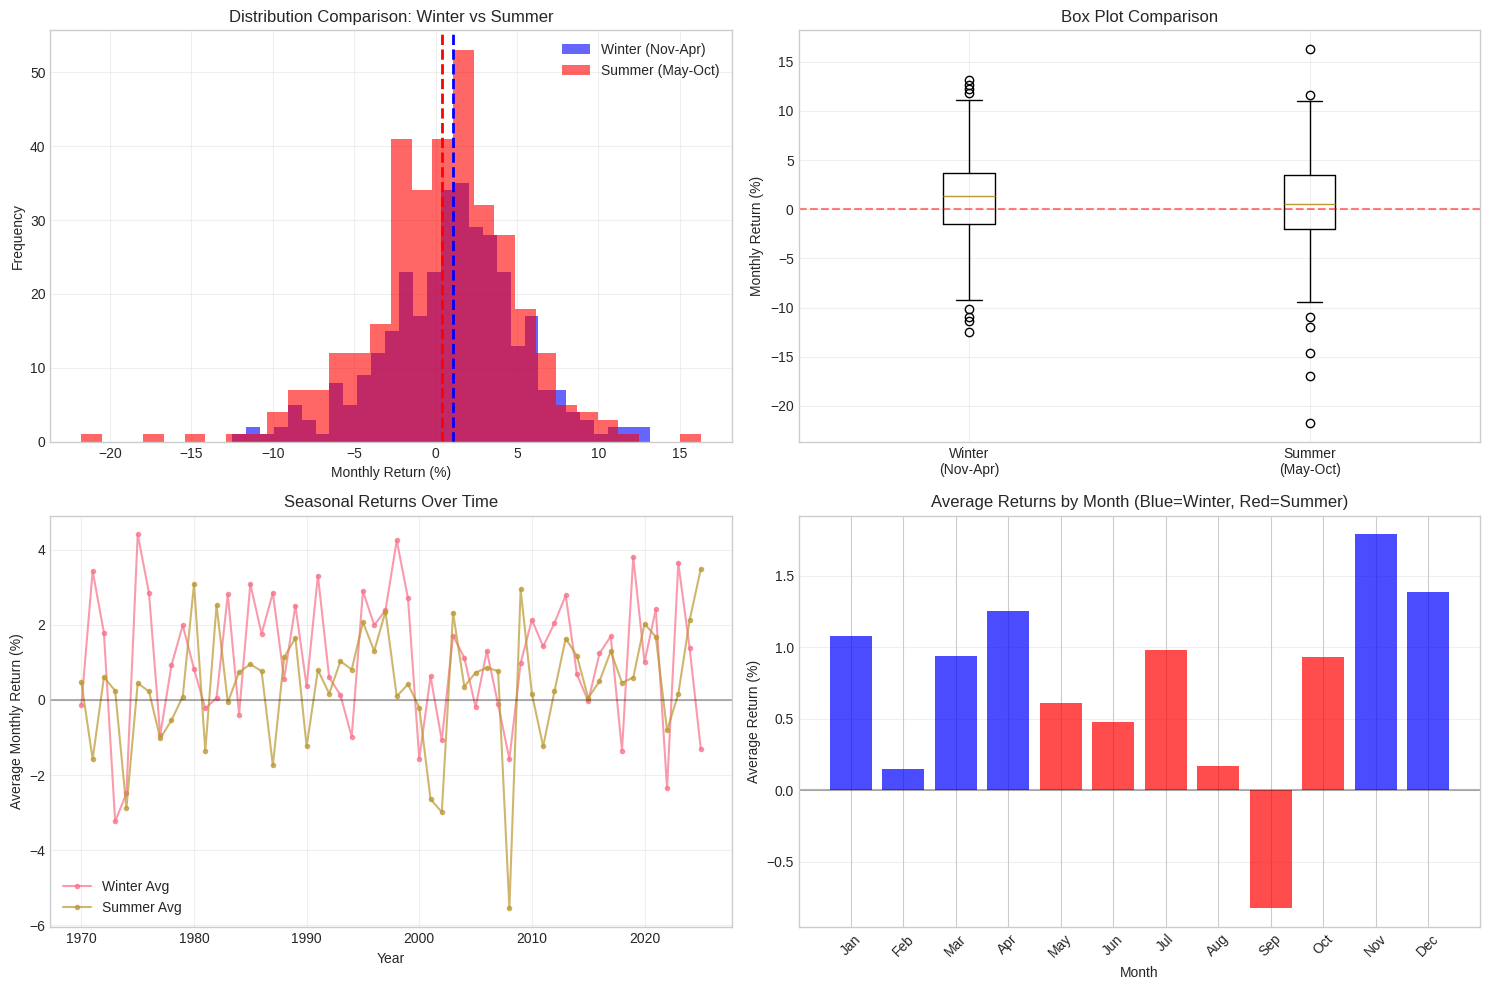

In [30]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Side-by-side histograms
axes[0, 0].hist(winter_returns, bins=30, alpha=0.6, label='Winter (Nov-Apr)', color='blue')
axes[0, 0].hist(summer_returns, bins=30, alpha=0.6, label='Summer (May-Oct)', color='red')
axes[0, 0].axvline(np.mean(winter_returns), color='blue', linestyle='--', linewidth=2)
axes[0, 0].axvline(np.mean(summer_returns), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Monthly Return (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution Comparison: Winter vs Summer')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot comparison
data_for_box = [winter_returns, summer_returns]
axes[0, 1].boxplot(data_for_box, labels=['Winter\n(Nov-Apr)', 'Summer\n(May-Oct)'])
axes[0, 1].set_ylabel('Monthly Return (%)')
axes[0, 1].set_title('Box Plot Comparison')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(alpha=0.3)

# 3. Time series of seasonal average returns
axes[1, 0].plot(df_sp500.index, df_sp500['Winter_Avg'], 
                label='Winter Avg', marker='o', markersize=3, alpha=0.7)
axes[1, 0].plot(df_sp500.index, df_sp500['Summer_Avg'], 
                label='Summer Avg', marker='o', markersize=3, alpha=0.7)
axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Monthly Return (%)')
axes[1, 0].set_title('Seasonal Returns Over Time')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Bar chart of average by individual month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avgs = [df_sp500[month].mean() for month in month_order]
colors = ['blue' if month in winter_months else 'red' for month in month_order]

axes[1, 1].bar(month_order, month_avgs, color=colors, alpha=0.7)
axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Return (%)')
axes[1, 1].set_title('Average Returns by Month (Blue=Winter, Red=Summer)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()